# Vulnerability Detection in Source Code using deep learning algorithm

- Datasets are available at https://osf.io/d45bw/.
- Distribution of datasets: Training (80%), Validation ( 10%), and Testing ( 10%).
- The dataset contains the source code of 1.27 million functions extracted from open source software and    labelled for possible vulnerabilities using static analysis. 
- Starting with the function name, the raw source code for each function is kept as a variable-length UTF-8 string.Each function has five binary 'vulnerability' labels, one for each of the four most prominent CWEs in our data plus all others:
    - CWE-120 (3.7% of functions)
    - CWE-119 (1.9% of functions)
    - CWE-469 (0.95% of functions)
    - CWE-476 (0.21% of functions)
    - CWE-other (2.7% of functions)
- Each function may have several labelled CWEs.

## Data Pre-processing

Converting HDF5 files to python pickle

In [1]:
import h5py
import pandas as pd

Opening HDF5 file where the data is provided in three HDF5 files corresponding to an 80:10:10 train/validate/test split

In [2]:
data = h5py.File("Draper_VDISC_Dataset/VDISC_train.hdf5",'r') #train dataset 
#data = h5py.File("Draper_VDISC_Dataset/VDISC_validate.hdf5",'r') #validation dataset
#data = h5py.File("Draper_VDISC_Dataset/VDISC_test.hdf5",'r') #test dataset

In [3]:
print(type(data))

<class 'h5py._hl.files.File'>


In [4]:
#printing labeled datasets
print(data.keys())

<KeysViewHDF5 ['CWE-119', 'CWE-120', 'CWE-469', 'CWE-476', 'CWE-other', 'functionSource']>


In [5]:
# List all groups
data.visit(print)

CWE-119
CWE-120
CWE-469
CWE-476
CWE-other
functionSource


Generating a new dataframe from the HDF5 file

In [6]:
data_frame = pd.DataFrame(list(data['functionSource']))

In [7]:
print(data_frame)

                                                         0
0        b'clear_area(int startx, int starty, int xsize...
1        b'ReconstructDuList(Statement* head)\n{\n    S...
2        b'free_speaker(void)\n{\n   if(Lengths)\n     ...
3        b'mlx4_register_device(struct mlx4_dev *dev)\n...
4        b'Parse_Env_Var(void)\n{\n  char *p = getenv("...
...                                                    ...
1019466  b'visitICmpInst(ICmpInst &I) {\n  // We must c...
1019467  b'path_node_delete_chain(path_node * head)\n{\...
1019468  b'addrconf6_start (NMDevice *self)\n{\n\tNMDev...
1019469  b'Next(const SQObjectPtr &refpos, SQObjectPtr ...
1019470  b'EffectHealMaxHealth(SpellEffectIndex /*eff_i...

[1019471 rows x 1 columns]


In [8]:
data_frame['CWE-119']=list(data['CWE-119'])

In [9]:
print(data_frame['CWE-119'])

0          False
1          False
2          False
3          False
4           True
           ...  
1019466    False
1019467    False
1019468    False
1019469    False
1019470    False
Name: CWE-119, Length: 1019471, dtype: bool


In [10]:
data_frame['CWE-120']=list(data['CWE-120'])

In [11]:
print(data_frame['CWE-120'])

0          False
1          False
2          False
3          False
4           True
           ...  
1019466    False
1019467    False
1019468    False
1019469    False
1019470    False
Name: CWE-120, Length: 1019471, dtype: bool


In [12]:
data_frame['CWE-469']=list(data['CWE-469'])

In [13]:
print(data_frame['CWE-469'])

0          False
1          False
2          False
3          False
4          False
           ...  
1019466    False
1019467    False
1019468    False
1019469    False
1019470    False
Name: CWE-469, Length: 1019471, dtype: bool


In [14]:
data_frame['CWE-476']=list(data['CWE-476']) 

In [15]:
print(data_frame['CWE-476'])

0          False
1          False
2          False
3          False
4          False
           ...  
1019466    False
1019467    False
1019468    False
1019469    False
1019470    False
Name: CWE-476, Length: 1019471, dtype: bool


In [16]:
data_frame['CWE-other']=list(data['CWE-other']) 

In [17]:
print(data_frame['CWE-other'])

0          False
1          False
2          False
3          False
4           True
           ...  
1019466    False
1019467    False
1019468    False
1019469    False
1019470    False
Name: CWE-other, Length: 1019471, dtype: bool


In [18]:
data_frame.rename(columns={0:'functionSource'},inplace=True)

In [19]:
data_frame.iloc[0:5,0:]

,functionSource,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
0,"b'clear_area(int startx, int starty, int xsize...",False,False,False,False,False
1,b'ReconstructDuList(Statement* head)\n{\n S...,False,False,False,False,False
2,b'free_speaker(void)\n{\n if(Lengths)\n ...,False,False,False,False,False
3,b'mlx4_register_device(struct mlx4_dev *dev)\n...,False,False,False,False,False
4,"b'Parse_Env_Var(void)\n{\n char *p = getenv(""...",True,True,False,False,True


In [20]:
data_frame.to_pickle("VDISC_train.pickle")
data_frame.to_pickle("VDISC_validate.pickle")
data_frame.to_pickle("VDISC_test.pickle")

## Exploratory Data Analysis

## Learning Phase

### Importing libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.utils import class_weight
import pickle
from sklearn.metrics import ConfusionMatrixDisplay
import math

print("Tensorlfow version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Tensorlfow version:  2.6.0
Eager mode:  True
GPU is available


### Setting global variable

In [2]:
# Set the global value
WORDS_SIZE=10000
INPUT_SIZE=500
NUM_CLASSES=2
MODEL_NUM=0
EPOCHS=40

### Importing processed datasets

In [3]:
train=pd.read_pickle("VDISC_train.pickle")
validate=pd.read_pickle("VDISC_validate.pickle")
test=pd.read_pickle("VDISC_test.pickle")
for dataset in [train,validate,test]:
    for col in range(1,6):
        dataset.iloc[:,col] = dataset.iloc[:,col].map({False: 0, True: 1})

# Create source code sdata for tokenization
x_all = train['functionSource']
#x_all = x_all.append(validate['functionSource'])
#x_all = x_all.append(test['functionSource'])

In [4]:
# Overview of the datasets
train.head()

,functionSource,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
0,"b'clear_area(int startx, int starty, int xsize...",0,0,0,0,0
1,b'ReconstructDuList(Statement* head)\n{\n S...,0,0,0,0,0
2,b'free_speaker(void)\n{\n if(Lengths)\n ...,0,0,0,0,0
3,b'mlx4_register_device(struct mlx4_dev *dev)\n...,0,0,0,0,0
4,"b'Parse_Env_Var(void)\n{\n char *p = getenv(""...",1,1,0,0,1


### Tokenizing the source codes

In [5]:
# Tokenizer with word-level
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=False)
#tokenizer.fit_on_texts(list(x_all))
tokenizer.fit_on_texts([x.decode('utf-8') for x in list(x_all)])
del(x_all)
print('Number of tokens: ',len(tokenizer.word_counts))


Number of tokens:  1094129


In [6]:
# Reducing to top N words
tokenizer.num_words = WORDS_SIZE

In [7]:
# Top 10 words
sorted(tokenizer.word_counts.items(), key=lambda x:x[1], reverse=True)[0:10]

[('if', 3126441),
 ('0', 2106459),
 ('return', 1745333),
 ('i', 1375259),
 ('1', 1186857),
 ('int', 1016932),
 ('null', 975347),
 ('the', 791897),
 ('t', 733766),
 ('n', 716010)]

### Create sequence files from the tokens

In [8]:
## Tokkenizing train data and create matrix
# list_tokenized_train = tokenizer.texts_to_sequences(train['functionSource'])
list_tokenized_train = tokenizer.texts_to_sequences([x.decode('utf-8') for x in train['functionSource']])
x_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, 
                                  maxlen=INPUT_SIZE,
                                  padding='post')
x_train = x_train.astype(np.int64)

In [9]:
## Tokkenizing test data and create matrix
list_tokenized_test = tokenizer.texts_to_sequences([x.decode('utf-8') for x in test['functionSource']])
x_test = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_test, 
                                 maxlen=INPUT_SIZE,
                                 padding='post')
x_test = x_test.astype(np.int64)

In [10]:
## Tokkenizing validate data and create matrix
list_tokenized_validate = tokenizer.texts_to_sequences([x.decode('utf-8') for x in validate['functionSource']])
x_validate = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_validate, 
                                 maxlen=INPUT_SIZE,
                                 padding='post')
x_validate = x_validate.astype(np.int64)

In [11]:
# Example data
test.iloc[0:5,1:6]

,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,1,1,0,0,1


### One-Hot-Enconding (OHE) on the datasets

In [12]:
y_train=[]
y_test=[] 
y_validate=[]

for col in range(1,6):
    y_train.append(tf.keras.utils.to_categorical(train.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))
    y_test.append(tf.keras.utils.to_categorical(test.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))
    y_validate.append(tf.keras.utils.to_categorical(validate.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))

In [13]:
# Example data
y_test[0][1:10]

array([[1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]], dtype=int64)

### Model Definition (CNN with Gaussian Noise and 5 Output Splits)


In [14]:
# Create a random weights matrix

random_weights = np.random.normal(size=(WORDS_SIZE, 13),scale=0.01)

In [15]:
# Must use non-sequential model building to create branches in the output layer
inp_layer = tf.keras.layers.Input(shape=(INPUT_SIZE,))
mid_layers = tf.keras.layers.Embedding(input_dim = WORDS_SIZE,
                                    output_dim = 13,
                                    weights=[random_weights],
                                    input_length = INPUT_SIZE)(inp_layer)
mid_layers = tf.keras.layers.Convolution1D(filters=512, kernel_size=(9), padding='same', activation='relu')(mid_layers)
mid_layers = tf.keras.layers.MaxPool1D(pool_size=5)(mid_layers)
mid_layers = tf.keras.layers.Dropout(0.5)(mid_layers)
mid_layers = tf.keras.layers.Flatten()(mid_layers)
mid_layers = tf.keras.layers.Dense(16, activation='relu')(mid_layers)
output1 = tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
output2 = tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
output3 = tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
output4 =tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
output5 = tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
model = tf.keras.Model(inp_layer,[output1,output2,output3,output4,output5])

# Define custom optimizers
adam = tf.keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1, decay=0.0, amsgrad=False)

## Compile model with metrics
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
print("CNN model built: ")
model.summary()

CNN model built: 
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 13)      130000      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 500, 512)     60416       embedding[0][0]                  
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 100, 512)     0           conv1d[0][0]                     
____________________________________________________________________________

C:\Users\alber\anaconda3\envs\data-latest\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


### Model Training

In [16]:
# due to lack of time and resources x_train and y_train are limited to 100000
# it can be changed as per resource available
limitation = 100000

# creating checkpoint for each epoch and saving the ones that are improvement from old epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='model/model-ALL-{epoch:02d}.hdf5',
                                                 save_best_only=True, 
                                                 save_freq='epoch', 
                                                 verbose=1)

# as gpu resources gets maxed out, using tf with CPU is implemented
with tf.device("CPU:0"):
    history = model.fit(x = x_train[0:limitation],
              y = [y_train[0][0:limitation], y_train[1][0:limitation], y_train[2][0:limitation], y_train[3][0:limitation], y_train[4][0:limitation]],
              validation_data = (x_validate[0:limitation], [y_validate[0][0:limitation], y_validate[1][0:limitation], y_validate[2][0:limitation], y_validate[3][0:limitation], y_validate[4][0:limitation]]),
              epochs = EPOCHS,
              batch_size = 128,
              verbose =2,
              callbacks = cp_callback)

with open('history/History-ALL-40EP-CNN', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)


Epoch 1/40
782/782 - 296s - loss: 0.9621 - dense_1_loss: 0.1981 - dense_2_loss: 0.2428 - dense_3_loss: 0.1432 - dense_4_loss: 0.1631 - dense_5_loss: 0.2149 - dense_1_accuracy: 0.9756 - dense_2_accuracy: 0.9627 - dense_3_accuracy: 0.9967 - dense_4_accuracy: 0.9840 - dense_5_accuracy: 0.9646 - val_loss: 0.4375 - val_dense_1_loss: 0.0909 - val_dense_2_loss: 0.1533 - val_dense_3_loss: 0.0154 - val_dense_4_loss: 0.0530 - val_dense_5_loss: 0.1248 - val_dense_1_accuracy: 0.9813 - val_dense_2_accuracy: 0.9636 - val_dense_3_accuracy: 0.9979 - val_dense_4_accuracy: 0.9905 - val_dense_5_accuracy: 0.9722

Epoch 00001: val_loss improved from inf to 0.43749, saving model to model\model-ALL-01.hdf5
Epoch 2/40
782/782 - 301s - loss: 0.4363 - dense_1_loss: 0.0908 - dense_2_loss: 0.1528 - dense_3_loss: 0.0149 - dense_4_loss: 0.0531 - dense_5_loss: 0.1246 - dense_1_accuracy: 0.9813 - dense_2_accuracy: 0.9636 - dense_3_accuracy: 0.9979 - dense_4_accuracy: 0.9905 - dense_5_accuracy: 0.9722 - val_loss: 0.43


Epoch 00012: val_loss improved from 0.42943 to 0.42924, saving model to model\model-ALL-12.hdf5
Epoch 13/40
782/782 - 308s - loss: 0.4297 - dense_1_loss: 0.0892 - dense_2_loss: 0.1500 - dense_3_loss: 0.0147 - dense_4_loss: 0.0529 - dense_5_loss: 0.1228 - dense_1_accuracy: 0.9813 - dense_2_accuracy: 0.9636 - dense_3_accuracy: 0.9979 - dense_4_accuracy: 0.9905 - dense_5_accuracy: 0.9722 - val_loss: 0.4295 - val_dense_1_loss: 0.0891 - val_dense_2_loss: 0.1499 - val_dense_3_loss: 0.0147 - val_dense_4_loss: 0.0528 - val_dense_5_loss: 0.1230 - val_dense_1_accuracy: 0.9813 - val_dense_2_accuracy: 0.9636 - val_dense_3_accuracy: 0.9979 - val_dense_4_accuracy: 0.9905 - val_dense_5_accuracy: 0.9722

Epoch 00013: val_loss did not improve from 0.42924
Epoch 14/40
782/782 - 309s - loss: 0.4297 - dense_1_loss: 0.0892 - dense_2_loss: 0.1500 - dense_3_loss: 0.0147 - dense_4_loss: 0.0529 - dense_5_loss: 0.1229 - dense_1_accuracy: 0.9813 - dense_2_accuracy: 0.9636 - dense_3_accuracy: 0.9979 - dense_4_ac


Epoch 00024: val_loss improved from 0.42633 to 0.42582, saving model to model\model-ALL-24.hdf5
Epoch 25/40
782/782 - 345s - loss: 0.4262 - dense_1_loss: 0.0883 - dense_2_loss: 0.1485 - dense_3_loss: 0.0146 - dense_4_loss: 0.0528 - dense_5_loss: 0.1220 - dense_1_accuracy: 0.9813 - dense_2_accuracy: 0.9636 - dense_3_accuracy: 0.9979 - dense_4_accuracy: 0.9905 - dense_5_accuracy: 0.9722 - val_loss: 0.4254 - val_dense_1_loss: 0.0882 - val_dense_2_loss: 0.1482 - val_dense_3_loss: 0.0146 - val_dense_4_loss: 0.0527 - val_dense_5_loss: 0.1218 - val_dense_1_accuracy: 0.9813 - val_dense_2_accuracy: 0.9636 - val_dense_3_accuracy: 0.9979 - val_dense_4_accuracy: 0.9905 - val_dense_5_accuracy: 0.9722

Epoch 00025: val_loss improved from 0.42582 to 0.42543, saving model to model\model-ALL-25.hdf5
Epoch 26/40
782/782 - 345s - loss: 0.4257 - dense_1_loss: 0.0882 - dense_2_loss: 0.1483 - dense_3_loss: 0.0146 - dense_4_loss: 0.0527 - dense_5_loss: 0.1220 - dense_1_accuracy: 0.9813 - dense_2_accuracy: 0


Epoch 00036: val_loss improved from 0.41498 to 0.41281, saving model to model\model-ALL-36.hdf5
Epoch 37/40
782/782 - 342s - loss: 0.4121 - dense_1_loss: 0.0851 - dense_2_loss: 0.1422 - dense_3_loss: 0.0142 - dense_4_loss: 0.0526 - dense_5_loss: 0.1180 - dense_1_accuracy: 0.9813 - dense_2_accuracy: 0.9636 - dense_3_accuracy: 0.9979 - dense_4_accuracy: 0.9905 - dense_5_accuracy: 0.9722 - val_loss: 0.4104 - val_dense_1_loss: 0.0847 - val_dense_2_loss: 0.1414 - val_dense_3_loss: 0.0142 - val_dense_4_loss: 0.0525 - val_dense_5_loss: 0.1175 - val_dense_1_accuracy: 0.9813 - val_dense_2_accuracy: 0.9636 - val_dense_3_accuracy: 0.9979 - val_dense_4_accuracy: 0.9905 - val_dense_5_accuracy: 0.9722

Epoch 00037: val_loss improved from 0.41281 to 0.41041, saving model to model\model-ALL-37.hdf5
Epoch 38/40
782/782 - 338s - loss: 0.4095 - dense_1_loss: 0.0845 - dense_2_loss: 0.1411 - dense_3_loss: 0.0142 - dense_4_loss: 0.0525 - dense_5_loss: 0.1173 - dense_1_accuracy: 0.9813 - dense_2_accuracy: 0

### Model Evaluation using Testing Set

In [26]:
# Load model with the latest and the lowest loss
from tensorflow.keras.models import load_model
model = load_model('model/model-ALL-40.hdf5')

In [27]:
# evaluate the model with all the test data available
with tf.device("CPU:0"):
    results = model.evaluate(x_test, y_test, batch_size=128)
    for num in range(0,len(model.metrics_names)):
        print(model.metrics_names[num]+': '+str(results[num]))

7965/7965 [==============================] - 888s 111ms/step - loss: 0.4037 - dense_1_loss: 0.0831 - dense_2_loss: 0.1402 - dense_3_loss: 0.0135 - dense_4_loss: 0.0528 - dense_5_loss: 0.1142 - dense_1_accuracy: 0.9811 - dense_2_accuracy: 0.9627 - dense_3_accuracy: 0.9979 - dense_4_accuracy: 0.9905 - dense_5_accuracy: 0.9726
loss: 0.40371495485305786
dense_1_loss: 0.08307576179504395
dense_2_loss: 0.140167236328125
dense_3_loss: 0.013531497679650784
dense_4_loss: 0.05275352671742439
dense_5_loss: 0.11418812721967697
dense_1_accuracy: 0.9810823202133179
dense_2_accuracy: 0.9627071022987366
dense_3_accuracy: 0.9979450106620789
dense_4_accuracy: 0.9904911518096924
dense_5_accuracy: 0.9725750088691711


### Check The Evaluation Metrics

In [28]:
# chacking the evaluation metrics with model 
with tf.device("CPU:0"):
    predicted = model.predict(x_test)

In [29]:
# the result for the prediction metrics
pred_test = [[],[],[],[],[]]
for col in range(0,len(predicted)):
    for row in predicted[col]:
        if row[0] >= row[1]:
            pred_test[col].append(0)
        else:
            pred_test[col].append(1)
            
for col in range(0,len(predicted)):
    print(pd.value_counts(pred_test[col]))

0    1019471
dtype: int64
0    1019471
dtype: int64
0    1019471
dtype: int64
0    1019471
dtype: int64
0    1019471
dtype: int64


### Evaluate on the testing set


In [30]:
'''
    CWE-120 - 1
    CWE-119 - 2
    CWE-469 - 3
    CWE-476 - 4
    CWE-other - 5
    
    the range is set from 1-5, but the list evalualtion is n-1 as it follows list type 
'''
label = { 1: "CWE-120",
    2: "CWE-119",
    3: "CWE-469",
    4 : "CWE-476",
    5: "CWE-other"}

In [31]:
for col in range(1,6):
    confusion = sklearn.metrics.confusion_matrix(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])
    tn, fp, fn, tp = confusion.ravel()
    print('\nThis is evaluation for column',label[col])
    print('\nTP:',tp)
    print('FP:',fp)
    print('TN:',tn)
    print('FN:',fn)

    ## Performance measure
    print('\nAccuracy: '+ str(sklearn.metrics.accuracy_score(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))
    print('Precision: '+ str(sklearn.metrics.precision_score(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))
    print('Recall: '+ str(sklearn.metrics.recall_score(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))
    print('F-measure: '+ str(sklearn.metrics.f1_score(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))
    print('Precision-Recall AUC: '+ str(sklearn.metrics.average_precision_score(y_true=test.iloc[:,col].to_numpy(), y_score=predicted[col-1][:,1])))
    print('AUC: '+ str(sklearn.metrics.roc_auc_score(y_true=test.iloc[:,col].to_numpy(), y_score=predicted[col-1][:,1])))
    print('MCC: '+ str(sklearn.metrics.matthews_corrcoef(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))
    
    


This is evaluation for column CWE-120

TP: 0
FP: 0
TN: 1000185
FN: 19286

Accuracy: 0.98108234564789


C:\Users\alber\anaconda3\envs\data-latest\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0
Recall: 0.0
F-measure: 0.0
Precision-Recall AUC: 0.08549876085410314
AUC: 0.8017372810866659


C:\Users\alber\anaconda3\envs\data-latest\lib\site-packages\sklearn\metrics\_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC: 0.0

This is evaluation for column CWE-119

TP: 0
FP: 0
TN: 981452
FN: 38019

Accuracy: 0.9627071294818588


C:\Users\alber\anaconda3\envs\data-latest\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0
Recall: 0.0
F-measure: 0.0
Precision-Recall AUC: 0.13241721364040254
AUC: 0.7859551672541931


C:\Users\alber\anaconda3\envs\data-latest\lib\site-packages\sklearn\metrics\_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC: 0.0

This is evaluation for column CWE-469

TP: 0
FP: 0
TN: 1017376
FN: 2095

Accuracy: 0.9979450126585259


C:\Users\alber\anaconda3\envs\data-latest\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0
Recall: 0.0
F-measure: 0.0
Precision-Recall AUC: 0.012982258107381062
AUC: 0.8248651972256092


C:\Users\alber\anaconda3\envs\data-latest\lib\site-packages\sklearn\metrics\_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC: 0.0

This is evaluation for column CWE-476

TP: 0
FP: 0
TN: 1009777
FN: 9694

Accuracy: 0.9904911468791168


C:\Users\alber\anaconda3\envs\data-latest\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0
Recall: 0.0
F-measure: 0.0
Precision-Recall AUC: 0.015759308785190794
AUC: 0.6298502526664349


C:\Users\alber\anaconda3\envs\data-latest\lib\site-packages\sklearn\metrics\_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC: 0.0

This is evaluation for column CWE-other

TP: 0
FP: 0
TN: 991512
FN: 27959

Accuracy: 0.9725749923244507


C:\Users\alber\anaconda3\envs\data-latest\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0
Recall: 0.0
F-measure: 0.0
Precision-Recall AUC: 0.09539946663973156
AUC: 0.7539895843256882
MCC: 0.0


C:\Users\alber\anaconda3\envs\data-latest\lib\site-packages\sklearn\metrics\_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


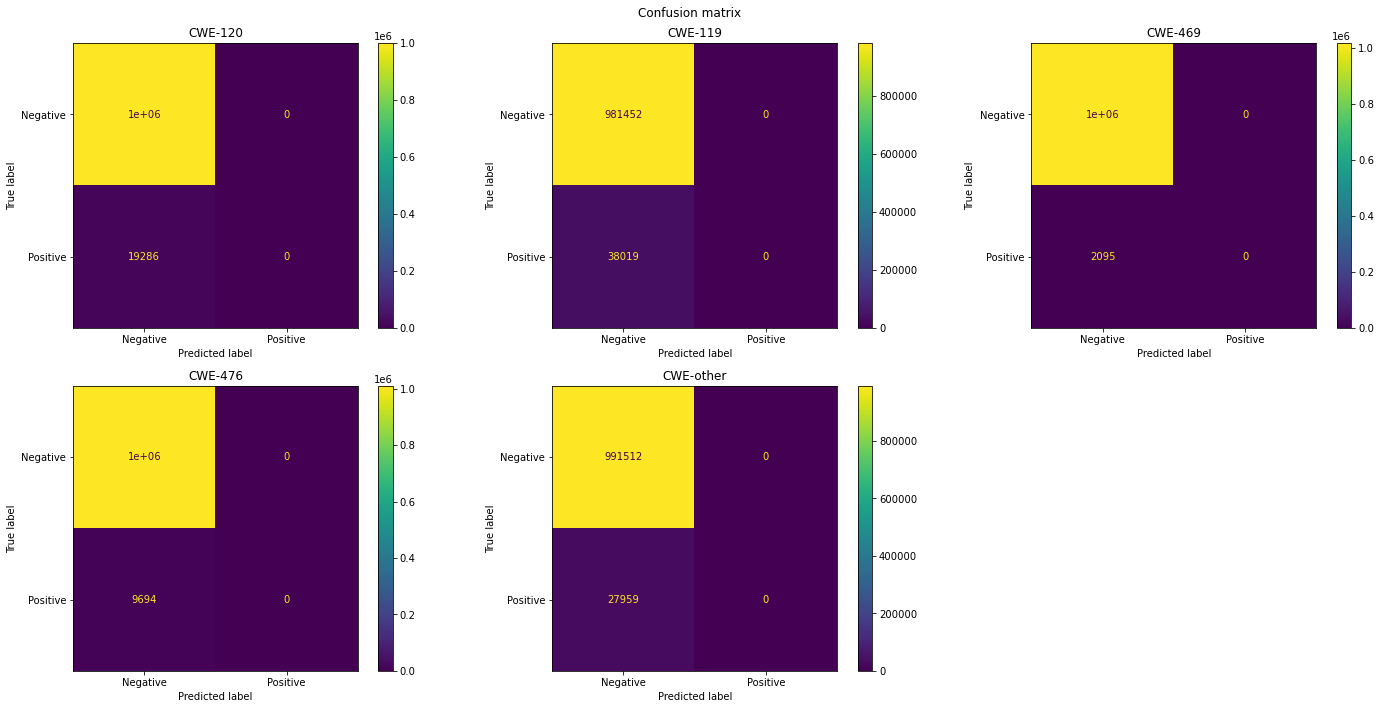

In [32]:
# confusion matrix for each category
i,j=0,0
PLOTS_PER_ROW = 3
fig, axs = plt.subplots(math.ceil(5/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 10))    
fig.suptitle("Confusion matrix")
for col in range(1,6):
    confusion = sklearn.metrics.confusion_matrix(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])
    tn, fp, fn, tp = confusion.ravel()
    cm = np.array([[tn,fp], [fn,tp]])
    ls = ["Negative", "Positive"] # your y labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls)
    disp.plot(ax=axs[i,j]) 
    axs[i, j].set_title(label[col])
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
        
fig.delaxes(axs[1,2])
fig.tight_layout()
plt.show()
    

In [33]:
history = None
with open('history/History-ALL-40EP-CNN', 'rb') as file_pi:
    history = pickle.load(file_pi)
#     pickle.dump(history.history, file_pi)

### Plot The Model's Training History

C:\Users\alber\AppData\Local\Temp/ipykernel_13244/3866507951.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0,0].plot(epochs_range, history['val_%s'%(model.metrics_names[6])], 'b', label='CWE-119', color='green')
C:\Users\alber\AppData\Local\Temp/ipykernel_13244/3866507951.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0,0].plot(epochs_range, history['val_%s'%(model.metrics_names[7])], 'b', label='CWE-120', color='blue')
C:\Users\alber\AppData\Local\Temp/ipykernel_13244/3866507951.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0,0].plot(epochs_range, history['val_%s'%(model.metrics_nam

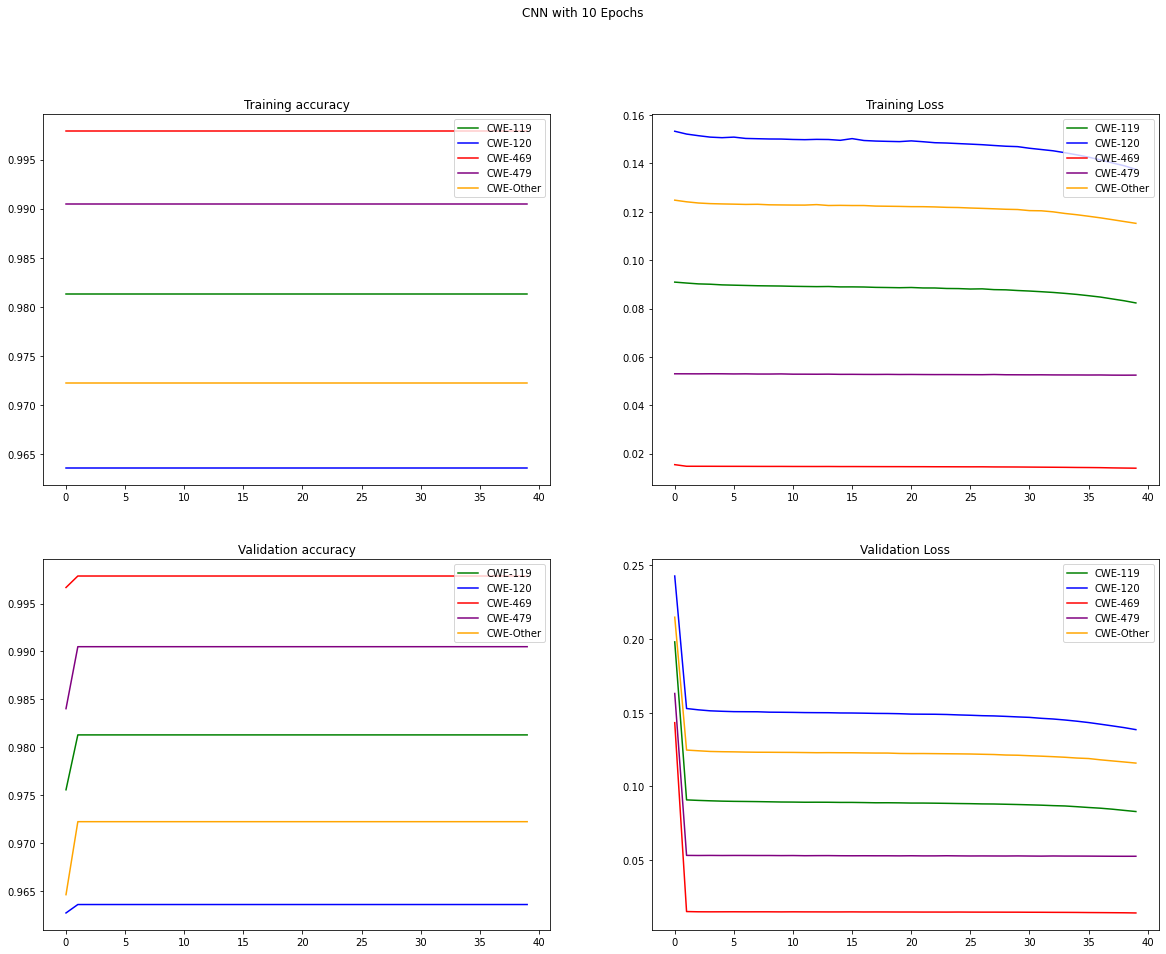

In [34]:
epochs_range = range(len(history[model.metrics_names[1]]))

fig, axs = plt.subplots(2, 2, figsize=(20,15))
fig.suptitle('CNN with 10 Epochs')

axs[0,0].plot(epochs_range, history['val_%s'%(model.metrics_names[6])], 'b', label='CWE-119', color='green')
axs[0,0].plot(epochs_range, history['val_%s'%(model.metrics_names[7])], 'b', label='CWE-120', color='blue')
axs[0,0].plot(epochs_range, history['val_%s'%(model.metrics_names[8])], 'b', label='CWE-469', color='red')
axs[0,0].plot(epochs_range, history['val_%s'%(model.metrics_names[9])], 'b', label='CWE-479', color='purple')
axs[0,0].plot(epochs_range, history['val_%s'%(model.metrics_names[10])], 'b', label='CWE-Other', color='orange')
axs[0,0].set_title('Training accuracy')
axs[0,0].legend()


axs[0,1].plot(epochs_range, history['val_%s'%(model.metrics_names[1])], 'b', label='CWE-119', color='green')
axs[0,1].plot(epochs_range, history['val_%s'%(model.metrics_names[2])], 'b', label='CWE-120', color='blue')
axs[0,1].plot(epochs_range, history['val_%s'%(model.metrics_names[3])], 'b', label='CWE-469', color='red')
axs[0,1].plot(epochs_range, history['val_%s'%(model.metrics_names[4])], 'b', label='CWE-479', color='purple')
axs[0,1].plot(epochs_range, history['val_%s'%(model.metrics_names[5])], 'b', label='CWE-Other', color='orange')
axs[0,1].set_title('Training Loss')
axs[0,1].legend()

axs[1,0].plot(epochs_range, history[model.metrics_names[6]], 'b', label='CWE-119', color='green')
axs[1,0].plot(epochs_range, history[model.metrics_names[7]], 'b', label='CWE-120', color='blue')
axs[1,0].plot(epochs_range, history[model.metrics_names[8]], 'b', label='CWE-469', color='red')
axs[1,0].plot(epochs_range, history[model.metrics_names[9]], 'b', label='CWE-479', color='purple')
axs[1,0].plot(epochs_range, history[model.metrics_names[10]], 'b', label='CWE-Other', color='orange')
axs[1,0].set_title('Validation accuracy')
axs[1,0].legend()


axs[1,1].plot(epochs_range, history[model.metrics_names[1]], 'b', label='CWE-119', color='green')
axs[1,1].plot(epochs_range, history[model.metrics_names[2]], 'b', label='CWE-120', color='blue')
axs[1,1].plot(epochs_range, history[model.metrics_names[3]], 'b', label='CWE-469', color='red')
axs[1,1].plot(epochs_range, history[model.metrics_names[4]], 'b', label='CWE-479', color='purple')
axs[1,1].plot(epochs_range, history[model.metrics_names[5]], 'b', label='CWE-Other', color='orange')
axs[1,1].set_title('Validation Loss')
axs[1,1].legend()
